# Implicitly defined reachable sets within GCS

In [7]:
import numpy as np
from large_gcs.graph_generators.hor_vert_gcs import create_simplest_hor_vert_graph
from pydrake.all import (MathematicalProgram, Solve)


## Simple Example Graph

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


100%|██████████| 5/5 [00:00<00:00, 5814.12it/s]

Adding edge s -> p0
Adding edge s -> p1
Adding edge p2 -> t
Adding edge p0 -> p2
Adding edge p1 -> p2


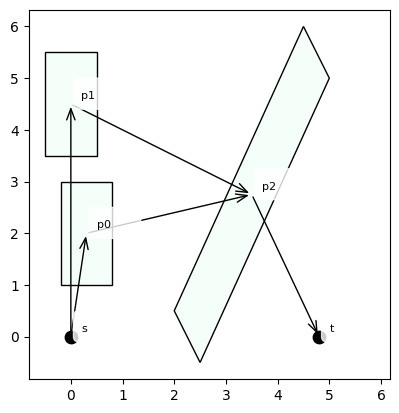

In [2]:
g = create_simplest_hor_vert_graph()
g.plot_sets()
g.plot_edges()
g.plot_set_labels()

INFO:drake:Solved GCS shortest path using Gurobi with convex_relaxation=false and preprocessing=false and no rounding.


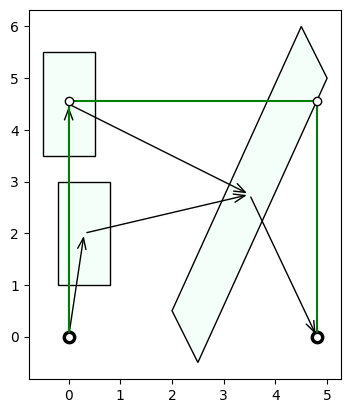

In [3]:
sol = g.solve_shortest_path()
g.plot_sets()
g.plot_edges()
g.plot_path(sol.ambient_path)

# Sampling Procedure
To determine if A is dominated by B

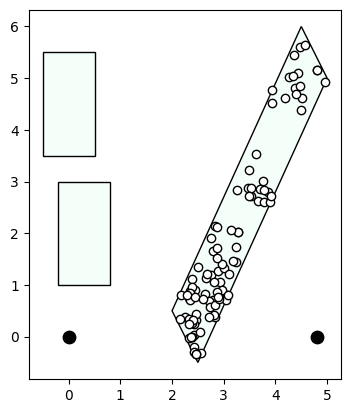

In [4]:
# Sample 100 points in p2
p2_samples = np.array(g.vertices["p2"].convex_set.get_samples(100))
g.plot_sets()
g.plot_points(p2_samples)

In [8]:
# Project these samples into revised set based on path

def project_sample_to_revised_set(sample, vertex_sampled, active_edges):
    prog = MathematicalProgram()
    vertex_names = [active_edges[0][0]] + [edge[1] for edge in active_edges]
    # gcs vertices
    vertices = [g.vertices[name].gcs_vertex for name in vertex_names]
    edges = [g.edges[edge].gcs_edge for edge in active_edges]
    for v in vertices:
        if v.set().ambient_dimension() == 0:
            continue
        prog.AddDecisionVariables(v.x())
        v.set().AddPointInSetConstraints(prog, v.x())

        # Vertex Costs
        for binding in v.GetCosts():
            prog.AddCost(binding)
        # Vertex Constraints
        for binding in v.GetConstraints():
            prog.AddConstraint(binding)
    
    for e in edges:
        # Edge Costs
        for binding in e.GetCosts():
            prog.AddCost(binding)
        # Edge Constraints
        for binding in e.GetConstraints():
            prog.AddConstraint(binding)
    
    result = Solve(prog)
    if not result.is_success():
        raise RuntimeError("Failed to solve")
    return result

# active_edges = [("s", "p1"), ("p1", "p2")]
active_edges = [("s", "p1"), ("p1", "p2"), ("p2", "t")]
res = project_sample_to_revised_set(p2_samples[0], "p2", active_edges)
print(f"optimal_cost: {res.get_optimal_cost()}")
print(sol.cost)

optimal_cost: 32.313599993457515
32.3136001328432
